In [0]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import warnings
import numpy as np
import tensorflow as tf
#LibROSA and SciPy py libs for processing audio.
warnings.filterwarnings("ignore")

In [52]:
#uploaded folder through zip and extracted it.
from zipfile import ZipFile
file_name = "/content/train (1).zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')


Done


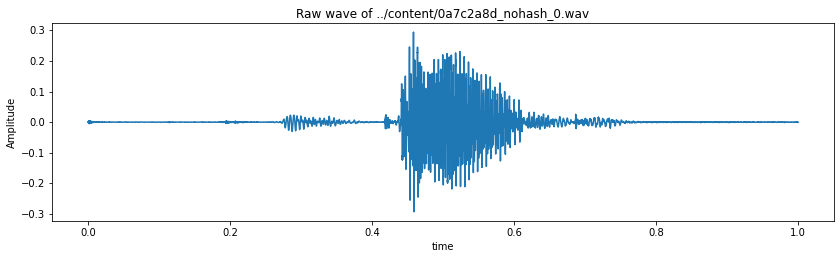

In [54]:
#obtaining file path and checking out an example
train_audio_path = '/content/'
samples, sample_rate = librosa.load(train_audio_path+'0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../content/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [23]:
#sampling rate
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [55]:
#sample rate is 16000hz , resampling to 8000Hz
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [0]:
labels=os.listdir(train_audio_path)

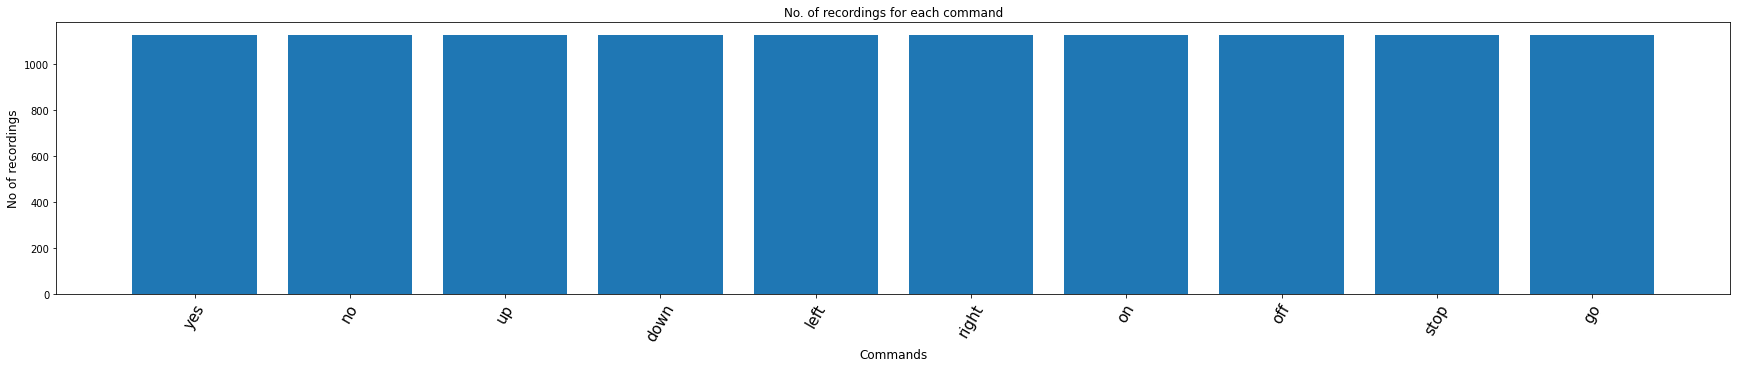

In [29]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [0]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
#list of label words

(array([2.000e+01, 1.000e+01, 0.000e+00, 3.000e+01, 1.300e+02, 9.000e+01,
        3.000e+02, 2.100e+02, 3.200e+02, 1.015e+04]),
 array([0.469375 , 0.5224375, 0.5755   , 0.6285625, 0.681625 , 0.7346875,
        0.78775  , 0.8408125, 0.893875 , 0.9469375, 1.       ]),
 <a list of 10 Patch objects>)

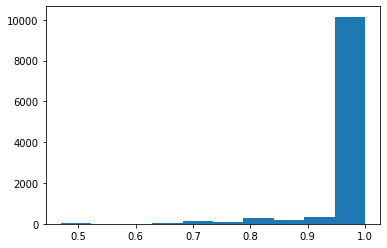

In [58]:
#distribution of duration for each label (graph plotted)
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [34]:
#resampling into labels
train_audio_path = '/content/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [0]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [0]:
#conversion to one hot veecs.
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [0]:
#train 80% and validate rest
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [0]:
#used conv1d layers since it has convolution only in one direction.
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)


In [64]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [95]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[mc], batch_size=32, validation_data=(x_val,y_val))

Train on 7872 samples, validate on 1968 samples
Epoch 1/100
7872/7872 [==============================] - 4s 462us/step - loss: 2.3028 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 2/100
7872/7872 [==============================] - 4s 461us/step - loss: 2.3028 - accuracy: 0.0945 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 3/100
7872/7872 [==============================] - 4s 452us/step - loss: 2.3028 - accuracy: 0.0913 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 4/100
7872/7872 [==============================] - 3s 437us/step - loss: 2.3028 - accuracy: 0.0957 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 5/100
7872/7872 [==============================] - 3s 439us/step - loss: 2.3028 - accuracy: 0.0938 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 6/100
7872/7872 [==============================] - 4s 448us/step - loss: 2.3028 - accuracy: 0.0925 - val_loss: 2.3026 - val_accuracy: 0.0996
Epoch 7/100
7872/7872 [==============================] - 4s 446us/step

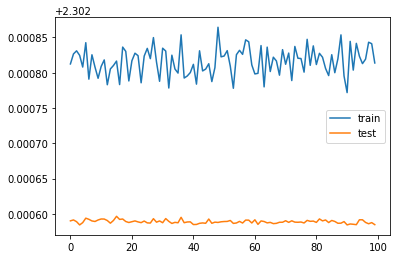

In [102]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [97]:
from keras.models import load_model
model=load_model('best_model.hdf5')

OSError: ignored

In [0]:
#function to predict new audio
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [104]:
#making predictions on validtion data
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: no


In [105]:
print("Text:",predict(samples))

Text: go


In [0]:
#doesnot work., coz zip did not accomadate all